# CENTRALITY IS ALL YOU NEED
## LFN Project

### Description of the project
- **Aim**: try to detect the most influential political figures and their political party.

## Load libraries

In [195]:
#!pip install networkit
#!pip install pyvis
import networkx as nx
import networkit as nk
import csv
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
from pyvis.network import Network
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from functools import reduce

## Loading of the graph and calculation of some metrics

In [196]:
edges = pd.read_csv("data/fb-pages-politician.edges", sep = ",", header=None)
nodes = pd.read_csv("data/fb-pages-politician.nodes", sep = ",")

In [197]:
nodes

,id,name,new_id
0,127397457601670,陳根德,1661
1,169014523134260,林淑芬,52
2,295363753921281,Chris White,3477
3,613631835423903,Stewart Hosie MP,3193
4,284882801581896,Frank Schäffler,4425
...,...,...,...
5903,342943772496246,Kevin Byrne,3778
5904,193944157325672,Timur Husein,439
5905,142026376065,Jeremy Lefroy,159
5906,294019144024664,Ileana Argentin,107


In [198]:
#needs a dictionary in order to relabel the nodes
labelsDict = pd.Series(nodes.name.values,index=nodes.new_id).to_dict()

In [199]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edges,0, 1)
G = nx.relabel_nodes(G, labelsDict)

In [200]:
G.is_directed()

False

In [201]:
nkG = nk.nxadapter.nx2nk(G)

In [202]:
import math
41702/(math.factorial(5906)/(2*math.factorial(5904)))

0.002391517344981051

In [203]:
print("Is G connected? ",nx.is_connected(G))
print("Number of connected components: ", nx.number_connected_components(G))

Is G connected?  True
Number of connected components:  1


In [204]:
#connected components with networkit
cc = nk.components.ConnectedComponents(nkG)
cc.run()
print("number of components ", cc.numberOfComponents())
print("map of component size: ", cc.getComponentSizes())

number of components  1
map of component size:  {0: 5906}


In [205]:
#diameter (estimate)
#This algorithm gives an estimation of the diameter of a given graph. The algorithm is based on the ExactSumSweep algorithm presented in Michele Borassi, Pierluigi Crescenzi, Michel Habib, Walter A. Kosters, Andrea Marino, Frank W. Takes: http://www.sciencedirect.com/science/article/pii/S0304397515001644.
diam = nk.distance.Diameter(nkG,algo=1)
diam.run()
diam.getDiameter() 
#The return value of getDiameter is a pair of integers: the lower bound and upper bound of the diameter. 
#In the case, that we computed the exact diameter, the diameter is the first value of the pair.

(14, 0)

In [206]:
#diameter (effective)
#The effective diameter is defined as the number of edges on average to reach a given ratio of all other nodes.
#The EffectiveDiameter(G, ratio=0.9) constructor expects an undirected graph and the ratio of nodes that should be connected. The ratio must be between in the interval (0,1].
ed = nk.distance.EffectiveDiameter(nkG)
ed.run()
ed.getEffectiveDiameter()

5.816796478157806

In [207]:
#effective diameter approximation
eda = nk.distance.EffectiveDiameterApproximation(nkG)
eda.run()
eda.getEffectiveDiameter()

5.865221808330511

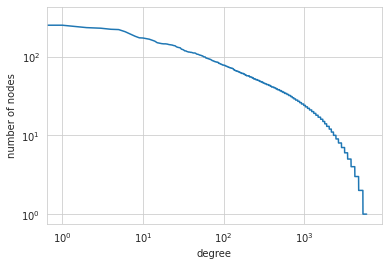

In [208]:
#degree distribution in our original graph
dd = sorted(nk.centrality.DegreeCentrality(nkG).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(dd)
plt.show()

In [209]:
#some info in our original graph if we are interested
communities = nk.community.detectCommunities(nkG)
nk.community.Modularity().getQuality(communities, nkG)

PLM(balanced,pc,turbo) detected communities in 0.024256467819213867 [s]
solution properties:
-------------------  ----------
# communities         31
min community size    10
max community size   603
avg. community size  190.516
modularity             0.867518
-------------------  ----------


0.867518048105929

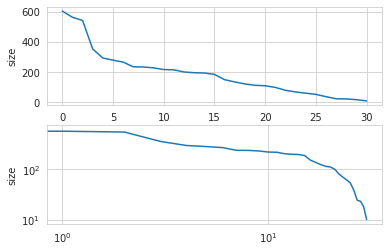

In [210]:
sizes = communities.subsetSizes()
sizes.sort(reverse=True)
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("size")
ax1.plot(sizes)

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("size")
ax2.plot(sizes)
plt.show()

## Closeness and Betweenness centrality

In [211]:
def centrality(G,alg, lib):
    if alg == "closeness" and lib == "nx":
        start_time = time.time()
        colsenessCentrality_nx = nx.closeness_centrality(G)
        print("--- %s seconds ---" % (time.time() - start_time))
        return colsenessCentrality_nx
    if alg == "betweenness" and lib == "nx":
        start_time = time.time()
        betweennessCentrality_nx = nx.betweenness_centrality(G)
        print("--- %s seconds ---" % (time.time() - start_time))
        return betweennessCentrality_nx
    if alg == "closeness" and lib == "nk":
        start_time = time.time()
        # default normalized=False
        nkColsenessCentrality = nk.centrality.Closeness(G,True,False).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkColsenessCentrality.ranking()
    if alg == "betweenness" and lib == "nk":
        start_time = time.time()
        # default normalized=False
        nkBetweennessCentrality = nk.centrality.Betweenness(G,True,False).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkBetweennessCentrality.ranking()
    if alg == "approxclose" and lib == "nk":
        start_time = time.time()
        # default normalized=False
        nkApproxColsenessCentrality = nk.centrality.ApproxCloseness(G,100, epsilon=0.05, normalized=True).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkApproxColsenessCentrality.ranking()
    if alg == "approxbet" and lib == "nk":
        start_time = time.time()
        nkApproxBetweennessCentrality = nk.centrality.ApproxBetweenness(G,epsilon=0.05).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkApproxBetweennessCentrality.ranking()

In [212]:
#centrality(G,"closeness","nx")

In [213]:
cc = centrality(nkG,"closeness","nk")

--- 0.49219703674316406 seconds ---


In [214]:
top10cc = dict(cc[:10])
keys10cc = list(top10cc.keys())
values10cc = list(top10cc.values())
nodesTop10cc = nodes.set_index("new_id").loc[keys10cc]
nodesTop10cc["cc"] = values10cc
nodesTop10cc

,id,name,cc
new_id,,,
703,168468263243635,Sylviane Bulteau,0.358857
853,336733203010225,Assemblyman Ray Walter,0.323508
941,384662044972285,"Norbert Spinrath, MdB",0.320471
855,232363686957754,Alexander Kulitz,0.317422
228,449533531817208,Alejandra Morlan,0.312467
157,728842613851000,Margaret Quirk MLA,0.310855
50,169196224815,Giovanni Capriglione,0.309697
219,1008920055906510,Monika Lazar,0.307536
810,425788730806692,Pierre Moreau,0.305547


In [215]:
#centrality(G,"betweenness","nx")

In [216]:
bc = centrality(nkG,"betweenness","nk")

--- 4.553990602493286 seconds ---


In [217]:
top10bc = dict(bc[:10])
keys10bc = list(top10bc.keys())
values10bc = list(top10bc.values())
nodesTop10bc = nodes.set_index("new_id").loc[keys10bc]
nodesTop10bc["bc"] = values10bc
nodesTop10bc

,id,name,bc
new_id,,,
703,168468263243635,Sylviane Bulteau,0.536616
177,148900938515423,Sofie Carsten Nielsen,0.111042
157,728842613851000,Margaret Quirk MLA,0.108292
810,425788730806692,Pierre Moreau,0.096549
255,326547101058452,Reinhard Brandl,0.090176
140,397307097023253,Justine Elliot MP,0.074552
50,169196224815,Giovanni Capriglione,0.070736
951,229547190392110,"Laurin Liu, Candidate NPD, RDMI",0.068160
138,662955787059972,Shane King MP- Labor for Kurwongbah,0.063586


In [218]:
acc = centrality(nkG,"approxclose","nk")

--- 0.05096030235290527 seconds ---


In [219]:
top10acc = dict(acc[:10])
keys10acc = list(top10acc.keys())
values10acc = list(top10acc.values())
nodesTop10acc = nodes.set_index("new_id").loc[keys10acc]
nodesTop10acc["acc"] = values10acc
nodesTop10acc

,id,name,acc
new_id,,,
703,168468263243635,Sylviane Bulteau,0.364964
853,336733203010225,Assemblyman Ray Walter,0.335570
855,232363686957754,Alexander Kulitz,0.326797
941,384662044972285,"Norbert Spinrath, MdB",0.326797
157,728842613851000,Margaret Quirk MLA,0.325733
810,425788730806692,Pierre Moreau,0.324675
233,1457854404494601,Hervé Gaymard,0.314465
228,449533531817208,Alejandra Morlan,0.313480
857,150237258650302,Cynthia Viteri,0.312500


In [220]:
abc = centrality(nkG,"approxbet","nk")

--- 0.9781231880187988 seconds ---


In [221]:
top10abc = dict(abc[:10])
keys10abc = list(top10abc.keys())
values10abc = list(top10abc.values())
nodesTop10abc = nodes.set_index("new_id").loc[keys10abc]
nodesTop10abc["abc"] = values10abc
nodesTop10abc

,id,name,abc
new_id,,,
703,168468263243635,Sylviane Bulteau,0.264545
157,728842613851000,Margaret Quirk MLA,0.059548
177,148900938515423,Sofie Carsten Nielsen,0.057153
810,425788730806692,Pierre Moreau,0.047570
255,326547101058452,Reinhard Brandl,0.042094
140,397307097023253,Justine Elliot MP,0.035934
50,169196224815,Giovanni Capriglione,0.033881
951,229547190392110,"Laurin Liu, Candidate NPD, RDMI",0.033539
308,342928465888942,Alain Leboeuf,0.031828


In [222]:
#visualize a subgraph
#H = G.subgraph(list(G.nodes)[:100])
#nt = Network('900px','1820px')
#nt.from_nx(H)
#nt.show('nx.html')

## Global and local clustering coefficient

In [223]:
#Returns approximate average average local clustering coefficient (networkit)
ACC_nkG = nk.globals.clustering(nkG)
ACC_nkG

0.42873273690610614

In [224]:
#Local Clustering Coefficient does not accept graphs with self loops.
#We remove them and compute the scores 
nkG.removeSelfLoops()
LCC_nkG = nk.centrality.LocalClusteringCoefficient(nkG).run()

In [225]:
len(LCC_nkG.scores()),LCC_nkG.scores()

(5906,
 [0.5739957716701902,
  0.4423558897243108,
  0.5113636363636364,
  0.819047619047619,
  0.7719298245614035,
  0.7333333333333333,
  0.7142857142857143,
  0.3745632424877708,
  0.5032377428307123,
  0.7631578947368421,
  0.3790849673202614,
  0.7350427350427351,
  0.3911421911421911,
  0.2367816091954023,
  0.5231372549019608,
  0.6102418207681366,
  0.5505050505050505,
  0.6628787878787878,
  0.7792207792207793,
  0.6413793103448275,
  0.4117647058823529,
  0.4788732394366197,
  0.7660098522167488,
  0.578494623655914,
  0.25117845117845117,
  0.4767676767676768,
  0.673202614379085,
  0.6773109243697479,
  0.4250380517503805,
  0.3841313269493844,
  0.4231578947368421,
  0.5245143385753932,
  0.8260869565217391,
  0.3886832363828662,
  0.19473180076628352,
  0.6193181818181818,
  0.37462537462537465,
  0.5285024154589372,
  0.8382352941176471,
  0.4919636617749825,
  0.3075091575091575,
  0.20425129900803024,
  0.783625730994152,
  0.4439746300211416,
  0.6623655913978495,
  0

In [226]:
#Returns average clustering coefficient with networkx
ACC_nxG = nx.average_clustering(G)
ACC_nxG

0.38526532797801083

In [227]:
#Networkx does not return an error for the self loops.
#However we obtain a dictionary of the same length, 
#so it removes implicity the self loops
LCC_nxG = nx.clustering(G)
len(LCC_nxG), LCC_nxG

(5906,
 {'Mark Bailey MP - Labor for Miller': 0.5739957716701902,
  'Jo-Ann Miller MP': 0.4423558897243108,
  'Senator Claire Moore': 0.5113636363636364,
  'Shane King MP-  Labor for Kurwongbah': 0.819047619047619,
  'Di Farmer MP': 0.7719298245614035,
  'Leanne Linard MP': 0.7333333333333333,
  'Aaron Harper MP': 0.7142857142857143,
  'Sénateur Pierre-Hugues Boisvenu': 0.3745632424877708,
  'Jackie Trad': 0.5032377428307123,
  'Jim Madden - Labor for Ipswich West': 0.7631578947368421,
  '邱志偉': 0.3790849673202614,
  'Grace Grace MP': 0.7350427350427351,
  'Senator Chris Ketter': 0.3911421911421911,
  'Bill Shorten MP': 0.2367816091954023,
  'Craig Crawford - Labor For Barron River': 0.5231372549019608,
  'Stirling Hinchliffe MP': 0.6102418207681366,
  'Mark Ryan MP': 0.5505050505050505,
  'Dr Anthony Lynham': 0.6628787878787878,
  'Joe Kelly MP': 0.7792207792207793,
  'Linus Power': 0.6413793103448275,
  'Luke Howarth': 0.4117647058823529,
  'Andrew Leigh MP': 0.4788732394366197,
  'Do

## Random Graphs

In [228]:
#Erdös-Renyi model
ERD = nk.generators.ErdosRenyiGenerator(G.number_of_nodes(), 0.2).generate()
print(ERD.numberOfNodes(), ERD.numberOfEdges())
#nk.community.detectCommunities(ERD)

5906 3487150


In [229]:
#Simple variant of Erdös-Renyi model
#The node set is partitioned into a given number of subsets. Nodes within the same subset have a higher edge probability.
CRG = nk.generators.ClusteredRandomGraphGenerator(G.number_of_nodes(), 4, 0.2, 0.002).generate()
print(CRG.numberOfNodes(), CRG.numberOfEdges())
#nk.community.detectCommunities(CRG)

5906 897646


In [230]:
#Chung-Lu model
degreeSequence = [nkG.degree(v) for v in nkG.iterNodes()]
clgen = nk.generators.ChungLuGenerator(degreeSequence)
CLG = clgen.generate()
print(CLG.numberOfNodes(), CLG.numberOfEdges())
cc = nk.components.ConnectedComponents(CLG)
cc.run()
print("number of components ", cc.numberOfComponents())
print("map of component size: ", cc.getComponentSizes())
#nk.community.detectCommunities(CLG)

5906 41303
number of components  354
map of component size:  {0: 5551, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 2, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 

In [231]:
def generateRandGraphs(alg, nrGraphs, param):
    G = []
    
    if alg == "ER":
        nrNodes, prob = param
        for i in range(nrGraphs):
            ER = nk.generators.ErdosRenyiGenerator(nrNodes, prob).generate()
            G.append(ER)
    if alg == "CL":
        for i in range(nrGraphs):
            degreeSequence = param
            CL = nk.generators.ChungLuGenerator(degreeSequence).generate()
            G.append(CL)
    return G

## Significant check: z-score and p-values

In [232]:
# Generate random graphs
# let G' random graph
# let G original graph
# Compute metricslike E[F(G')], sigma[F(G')] of the random graphs 
# Compute z-score
def zscore(f,expect_FG, sigma_FG):
    #print(f,expect_FG,sigma_FG)
    z = (f - expect_FG)/sigma_FG;
    return z

# Compute p-values
# input: 
#    FG: list of features from graph G'
#    f: value of the feature from graph G

def pvalues(FG,f):
    plarger = sum(map(lambda x : x>= f, FG))/len(FG)
    psmaller = sum(map(lambda x : x<= f, FG))/len(FG)
    return plarger,psmaller



In [233]:
degreeSequence = [nkG.degree(v) for v in nkG.iterNodes()]

In [278]:
def generateDataFrame(G, alg, nrGraphs, algRnd):
    if algRnd == "ER":
        RndGraphs = generateRandGraphs("ER", nrGraphs, [G.numberOfNodes(), 0.0025])
    if algRnd == "CL":
        degreeSequence = [G.degree(v) for v in G.iterNodes()]
        RndGraphs = generateRandGraphs("CL", nrGraphs, degreeSequence)
        
    if alg == "CC":
        if algRnd == "ER":
            RndFeatures = list(map(
                nk.centrality.Closeness,
                RndGraphs,
                [True for i in range(nrGraphs)],
                [False for i in range(nrGraphs)]

            ))
        else:
            RndFeatures = list(map(
                nk.centrality.Closeness,
                RndGraphs,
                [True for i in range(nrGraphs)],
                [nk.centrality.ClosenessVariant.Generalized for i in range(nrGraphs)],
            ))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"closeness","nk"))
    if alg == "BC":
        RndFeatures = list(map(nk.centrality.Betweenness,
                               RndGraphs,
                               [True for i in range(nrGraphs)],
                               [False for i in range(nrGraphs)]))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"betweenness","nk"))
    if alg == "approxCC":
        RndFeatures = list(map(nk.centrality.ApproxCloseness,
                               RndGraphs,
                               [100 for i in range(nrGraphs)],
                               [0.05 for i in range(nrGraphs)],
                               [True for i in range(nrGraphs)]))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"approxclose","nk"))
    if alg == "approxBC":
        RndFeatures = list(map(nk.centrality.ApproxBetweenness,
                               RndGraphs,
                               [0.05 for i in range(nrGraphs)]))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"approxbet","nk"))
    
    
    if alg == "LCC":
        #Local Clustering Coefficient does not accept graphs with self loops.
        #We remove them and compute the scores 
        G.removeSelfLoops()
        RndFeatures = list(map(nk.centrality.LocalClusteringCoefficient,
                               RndGraphs,
                              ))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(nk.centrality.LocalClusteringCoefficient(G).run().ranking())
    
    RndFeaturesRanking = list(map(lambda obj: obj.ranking(), RndFeatures))
    # merge RndFeaturesRanking, we will obtain a list of (key,value) pairs 
    #representing the id of each node as key
    # and the closeness centrality as value
    RndFeaturesRankingMerged = list(itertools.chain(*RndFeaturesRanking))
    RndFeaturesRanking_df = pd.DataFrame(RndFeaturesRankingMerged)
    RndFeaturesRanking_df.columns = {"key":"key", "centrality":"value"}
    if alg == "LCC":
        RndFeaturesRanking_df.columns = {"key":"key", "clusteringCoeff":"value"}
    mean_by_key = RndFeaturesRanking_df.groupby("key").mean()
    std_by_key = RndFeaturesRanking_df.groupby("key").std()

    f.columns = {"key":"key","centrality":"value"}
    if alg == "LCC":
        f.columns = {"key":"key","clusteringCoeff":"value"}
    f = f.set_index('key').sort_index()
    if alg == "LCC":
        SignificanceDataFrame = pd.DataFrame(zscore(f["clusteringCoeff"],mean_by_key["clusteringCoeff"],std_by_key["clusteringCoeff"]))
        SignificanceDataFrame.columns = {"zscore"}
        SignificanceDataFrame["clusteringCoeff_f"] = f["clusteringCoeff"]
    else:
        SignificanceDataFrame = pd.DataFrame(zscore(f["centrality"],mean_by_key["centrality"],std_by_key["centrality"]))
        SignificanceDataFrame.columns = {"zscore"}
        SignificanceDataFrame["centrality_f"] = f["centrality"]
    SignificanceDataFrame["mean_rand"] = mean_by_key
    SignificanceDataFrame["std_rand"] = std_by_key
    
    listDataFrame = list(map(pd.DataFrame, RndFeaturesRanking))
    listDataFrame = list(map(lambda obj: (obj.set_index(0)).sort_index(),listDataFrame))
    DataFrameFeatures = reduce(lambda df1,df2: pd.merge(df1,df2, left_index=True, right_index=True), listDataFrame)
    if alg == "LCC":
        pvaluesDataFrame = DataFrameFeatures.join(SignificanceDataFrame['clusteringCoeff_f'])
        pvaluesDataFrame = DataFrameFeatures.join(SignificanceDataFrame['clusteringCoeff_f'])
        pvaluesDataFrame.columns = [1,2,3,4,5,6,7,8,9,10,'clusteringCoeff_f']
    
    else:
        pvaluesDataFrame = DataFrameFeatures.join(SignificanceDataFrame['centrality_f'])
        pvaluesDataFrame = DataFrameFeatures.join(SignificanceDataFrame['centrality_f'])
        pvaluesDataFrame.columns = [1,2,3,4,5,6,7,8,9,10,'centrality_f']
    
    pvaluesDataFrame['pvalue-ge'] = np.zeros(G.numberOfNodes())
    pvaluesDataFrame['pvalue-le'] = np.zeros(G.numberOfNodes())
    if alg == "LCC":
        pvaluesDataFrame['pvalue-ge'] = np.sum(pvaluesDataFrame[[1,2,3,4,5,6,7,8,9,10]].ge(pvaluesDataFrame['clusteringCoeff_f'],axis="index"), axis=1)/10
        pvaluesDataFrame['pvalue-le'] = np.sum(pvaluesDataFrame[[1,2,3,4,5,6,7,8,9,10]].le(pvaluesDataFrame['clusteringCoeff_f'],axis="index"), axis=1)/10
    else:
        pvaluesDataFrame['pvalue-ge'] = np.sum(pvaluesDataFrame[[1,2,3,4,5,6,7,8,9,10]].ge(pvaluesDataFrame['centrality_f'],axis="index"), axis=1)/10
        pvaluesDataFrame['pvalue-le'] = np.sum(pvaluesDataFrame[[1,2,3,4,5,6,7,8,9,10]].le(pvaluesDataFrame['centrality_f'],axis="index"), axis=1)/10
    SignificanceDataFrame['pvalue-ge'] = pvaluesDataFrame['pvalue-ge']
    SignificanceDataFrame['pvalue-le'] = pvaluesDataFrame['pvalue-le']
    
    
    return SignificanceDataFrame

In [235]:
df_test_CC = generateDataFrame(nkG, "CC", 10, "ER")

10it [00:05,  1.80it/s]


--- 0.49338531494140625 seconds ---


In [236]:
df_test_CC.sort_values("centrality_f")

,zscore,centrality_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
5296,-26.507677,0.098964,0.284956,0.007017,1.0,0.0
5295,-24.272284,0.109832,0.277525,0.006909,1.0,0.0
5559,-23.087077,0.111924,0.282878,0.007405,1.0,0.0
2518,-27.729411,0.120705,0.281166,0.005787,1.0,0.0
4612,-32.688713,0.123365,0.284281,0.004923,1.0,0.0
...,...,...,...,...,...,...
228,3.740177,0.312467,0.284380,0.007510,0.0,1.0
855,4.922091,0.317422,0.285206,0.006545,0.0,1.0
941,6.861193,0.320471,0.281704,0.005650,0.0,1.0


In [237]:
df_test_BC = generateDataFrame(nkG, "BC", 10, "ER")
df_test_CC = generateDataFrame(nkG, "CC", 10, "ER")
df_test_approxCC = generateDataFrame(nkG, "approxCC", 10, "ER")
df_test_approxBC = generateDataFrame(nkG, "approxBC", 10, "ER")

10it [01:01,  6.15s/it]
0it [00:00, ?it/s]

--- 4.66481614112854 seconds ---


10it [00:05,  1.80it/s]
0it [00:00, ?it/s]

--- 0.4909358024597168 seconds ---


10it [00:00, 19.19it/s]
0it [00:00, ?it/s]

--- 0.04805922508239746 seconds ---


10it [00:12,  1.22s/it]


--- 1.029616355895996 seconds ---


In [238]:
df_test_CC["pvalue-ge"].unique()

array([1. , 0.4, 0.9, 0. , 0.2, 0.8, 0.5, 0.1, 0.6, 0.3, 0.7])

In [239]:
df_test_BC_CL = generateDataFrame(nkG, "BC", 10, "CL")
df_test_CC_CL = generateDataFrame(nkG, "CC", 10, "CL")
df_test_approxCC_CL = generateDataFrame(nkG, "approxCC", 10, "CL")
df_test_approxBC_CL = generateDataFrame(nkG, "approxBC", 10, "CL")

10it [00:53,  5.33s/it]


--- 4.575884819030762 seconds ---


10it [00:04,  2.27it/s]


--- 0.4929838180541992 seconds ---


10it [00:00, 22.89it/s]
0it [00:00, ?it/s]

--- 0.04858708381652832 seconds ---


10it [00:08,  1.13it/s]


--- 0.9817960262298584 seconds ---


In [240]:
df_test_CC_CL['zscore'].describe()

count    5906.000000
mean       -6.127976
std         6.827439
min       -72.933579
25%        -8.661349
50%        -4.450010
75%        -0.831263
max         7.207671
Name: zscore, dtype: float64

In [241]:
df_test_BC_CL['zscore'].clip(-100, 100).describe()

count    5886.000000
mean        8.472383
std        23.479412
min       -25.360186
25%        -0.970932
50%        -0.357898
75%         3.996536
max       100.000000
Name: zscore, dtype: float64

In [242]:
df_test_BC_CL['zscore'].describe()

count    5886.000000
mean             inf
std              NaN
min       -25.360186
25%        -0.970932
50%        -0.357898
75%         3.996536
max              inf
Name: zscore, dtype: float64

In [243]:
df_test_approxCC_CL['zscore'].describe()

count    5832.000000
mean       -6.923951
std         7.031854
min      -409.399965
25%        -8.978165
50%        -5.664180
75%        -3.594454
max        41.040468
Name: zscore, dtype: float64

In [244]:
df_test_approxBC.describe()

,zscore,centrality_f,mean_rand,std_rand,pvalue-ge,pvalue-le
count,5906.000000,5906.000000,5906.000000,5906.000000,5906.000000,5906.000000
mean,-inf,0.000620,0.000430,0.000443,0.780985,0.481849
std,NaN,0.004215,0.000147,0.000142,0.362206,0.253402
min,-inf,0.000000,0.000040,0.000000,0.000000,0.000000
25%,-1.037116,0.000000,0.000317,0.000337,0.600000,0.300000
50%,-0.817806,0.000000,0.000436,0.000420,1.000000,0.400000
75%,-0.184111,0.000342,0.000515,0.000522,1.000000,0.600000
max,507.404517,0.268652,0.001110,0.001214,1.000000,1.000000


Text(0.5, 1.0, 'approxBC')

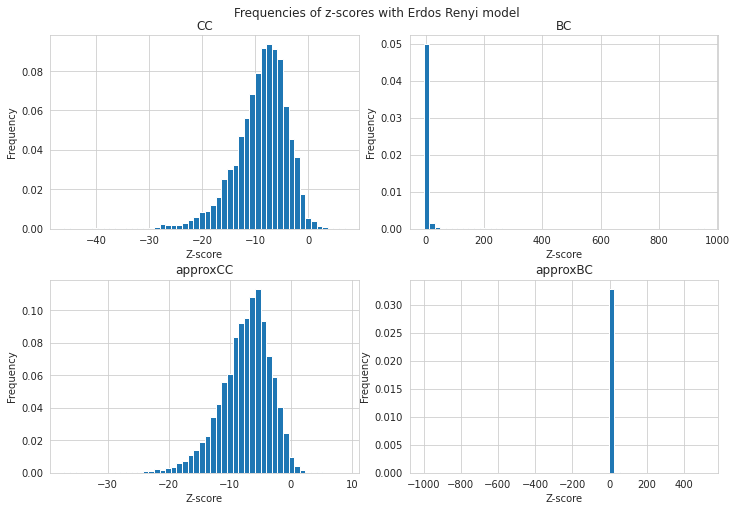

In [245]:
df_test_BC['zscore'] = df_test_BC['zscore'].clip(-1000,1000)
df_test_approxBC['zscore'] = df_test_approxBC['zscore'].clip(-1000,1000)

figure, axis = plt.subplots(2, 2, figsize=(10,7))
figure.suptitle("Frequencies of z-scores with Erdos Renyi model")
figure.tight_layout(h_pad=3, w_pad=2)
axis[0,0].hist(df_test_CC['zscore'], density=True, bins=50)
axis[0,0].set_ylabel('Frequency')
axis[0,0].set_xlabel('Z-score')
axis[0,0].set_title('CC')
axis[0,1].hist(df_test_BC['zscore'], density=True, bins=50)
axis[0,1].set_ylabel('Frequency')
axis[0,1].set_xlabel('Z-score')
axis[0,1].set_title('BC')
axis[1,0].hist(df_test_approxCC['zscore'], density=True, bins=50)
axis[1,0].set_ylabel('Frequency')
axis[1,0].set_xlabel('Z-score')
axis[1,0].set_title('approxCC')
axis[1,1].hist(df_test_approxBC['zscore'], density=True, bins=50)
axis[1,1].set_ylabel('Frequency')
axis[1,1].set_xlabel('Z-score')
axis[1,1].set_title('approxBC')

In [272]:
df_test_CC.loc[keys10cc][:5]

,zscore,centrality_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,6.932229,0.358857,0.284565,0.010717,0.0,1.0
853,5.085413,0.323508,0.287296,0.007121,0.0,1.0
941,5.248478,0.320471,0.285467,0.006669,0.0,1.0
855,4.811298,0.317422,0.283040,0.007146,0.0,1.0
228,3.672297,0.312467,0.281609,0.008403,0.0,1.0


In [273]:
df_test_BC.loc[keys10bc][:5]

,zscore,centrality_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,953.939943,0.536616,0.000968,0.000562,0.0,1.0
177,215.143842,0.111042,0.000930,0.000512,0.0,1.0
157,214.304741,0.108292,0.001014,0.000501,0.0,1.0
810,190.478641,0.096549,0.000902,0.000502,0.0,1.0
255,154.267225,0.090176,0.000895,0.000579,0.0,1.0


In [274]:
df_test_approxCC.loc[keys10acc][:5]

,zscore,centrality_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,8.800085,0.352113,0.284843,0.007644,0.0,1.0
853,5.340646,0.326797,0.290420,0.006811,0.0,1.0
855,5.019598,0.324675,0.278519,0.009195,0.0,1.0
941,4.447902,0.321543,0.282493,0.008780,0.0,1.0
157,4.310285,0.325733,0.283668,0.009759,0.0,1.0


In [275]:
df_test_approxBC.loc[keys10abc][:5]

,zscore,centrality_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,507.404517,0.268652,0.000397,0.000529,0.0,1.0
157,96.942355,0.054757,0.000397,0.000561,0.0,1.0
177,127.966916,0.055099,0.000555,0.000426,0.0,1.0
810,144.498069,0.054415,0.000397,0.000374,0.0,1.0
255,100.957266,0.044490,0.000436,0.000436,0.0,1.0


/home/cristianoc/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cristianoc/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'approxBC')

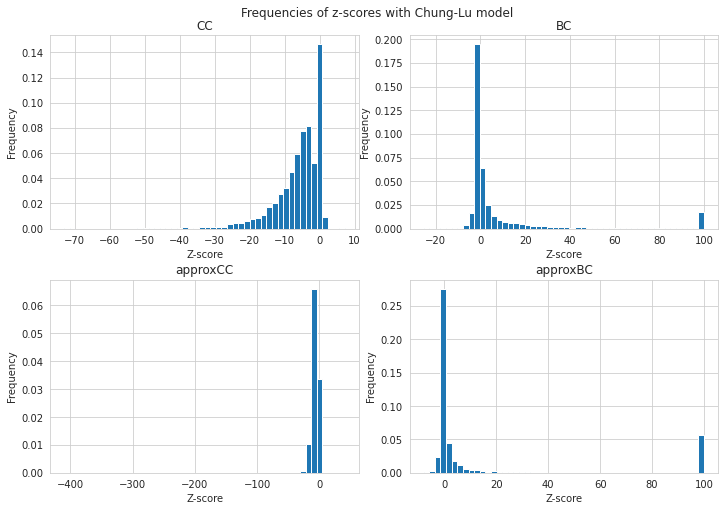

In [250]:
figure, axis = plt.subplots(2, 2, figsize=(10,7))
figure.suptitle("Frequencies of z-scores with Chung-Lu model")
figure.tight_layout(h_pad=3, w_pad=2)
axis[0,0].hist(df_test_CC_CL['zscore'], density=True, bins=50)
axis[0,0].set_ylabel('Frequency')
axis[0,0].set_xlabel('Z-score')
axis[0,0].set_title('CC')
axis[0,1].hist(df_test_BC_CL['zscore'].clip(-100, 100), density=True, bins=50)#clip bc of value inf
axis[0,1].set_ylabel('Frequency')
axis[0,1].set_xlabel('Z-score')
axis[0,1].set_title('BC')
axis[1,0].hist(df_test_approxCC_CL['zscore'], density=True, bins=50)
axis[1,0].set_ylabel('Frequency')
axis[1,0].set_xlabel('Z-score')
axis[1,0].set_title('approxCC')
axis[1,1].hist(df_test_approxBC_CL['zscore'].clip(-100, 100), density=True, bins=50)#clip bc of value inf
axis[1,1].set_ylabel('Frequency')
axis[1,1].set_xlabel('Z-score')
axis[1,1].set_title('approxBC')

In [251]:
df_test_CC_CL.loc[keys10cc][:5]

,zscore,centrality_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,7.207671,0.358857,0.320120,0.005375,0.0,1.0
853,0.677714,0.323508,0.318000,0.008128,0.2,0.8
941,1.728617,0.320471,0.310525,0.005754,0.0,1.0
855,0.089944,0.317422,0.316710,0.007918,0.4,0.6
228,-3.434644,0.312467,0.336335,0.006949,1.0,0.0


In [252]:
df_test_BC_CL.loc[keys10bc][:5]

,zscore,centrality_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,664.336050,0.536616,0.001810,0.000805,0.0,1.0
177,126.606275,0.111042,0.003739,0.000848,0.0,1.0
157,120.941352,0.108292,0.004133,0.000861,0.0,1.0
810,171.866434,0.096549,0.001334,0.000554,0.0,1.0
255,90.724104,0.090176,0.003829,0.000952,0.0,1.0


In [253]:
df_test_approxCC_CL.loc[keys10acc][:5]

,zscore,centrality_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,0.796581,0.353357,0.340132,0.016602,0.1,0.9
853,-3.287144,0.320513,0.343309,0.006935,1.0,0.0
855,-4.442292,0.316456,0.343851,0.006167,1.0,0.0
941,-1.040736,0.318471,0.329250,0.010357,0.9,0.1
157,-7.307598,0.315457,0.361830,0.006346,1.0,0.0


In [254]:
df_test_approxBC_CL.loc[keys10abc][:5]

,zscore,centrality_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,474.921828,0.267283,0.000670,0.000561,0.0,1.0
157,54.430946,0.053388,0.002058,0.000943,0.0,1.0
177,43.860091,0.057837,0.002058,0.001272,0.0,1.0
810,86.577775,0.048255,0.000545,0.000551,0.0,1.0
255,28.487784,0.045859,0.002207,0.001532,0.0,1.0


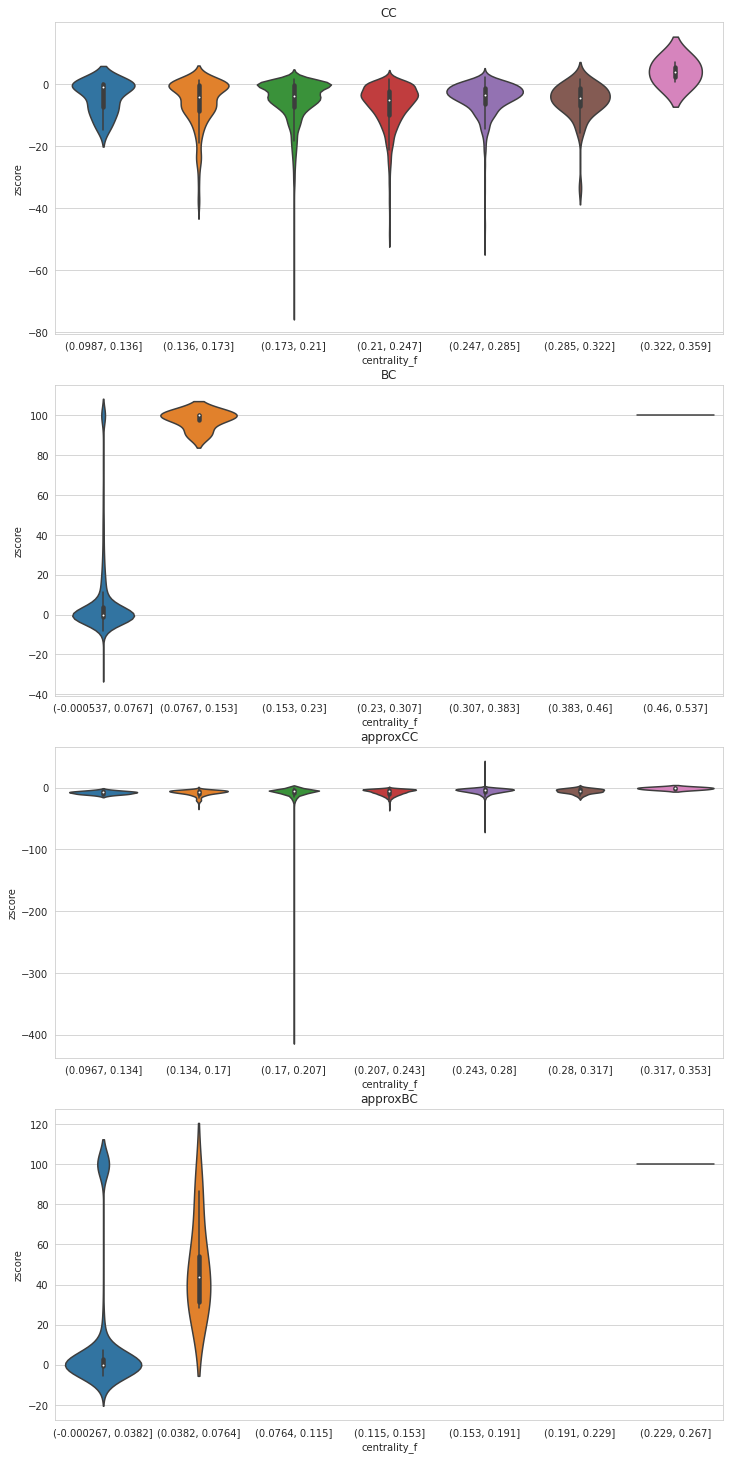

In [255]:
bins=7
df_test_BC_CL['zscore'] = df_test_BC_CL['zscore'].clip(-100,100)
df_test_approxBC_CL['zscore'] = df_test_approxBC_CL['zscore'].clip(-100,100)
fig, axes = plt.subplots(4,1,figsize=(10,20))
fig.tight_layout(h_pad=3)
sns.violinplot(x=pd.cut(df_test_CC_CL['centrality_f'], bins), y='zscore', data=df_test_CC_CL, ax=axes[0])
sns.violinplot(x=pd.cut(df_test_BC_CL['centrality_f'], bins), y='zscore', data=df_test_BC_CL, ax=axes[1])
sns.violinplot(x=pd.cut(df_test_approxCC_CL['centrality_f'], bins), y='zscore', data=df_test_approxCC_CL, ax=axes[2])
sns.violinplot(x=pd.cut(df_test_approxBC_CL['centrality_f'], bins), y='zscore', data=df_test_approxBC_CL, ax=axes[3])
axes[0].set_title("CC")
axes[1].set_title("BC")
axes[2].set_title("approxCC")
axes[3].set_title("approxBC")
plt.show()

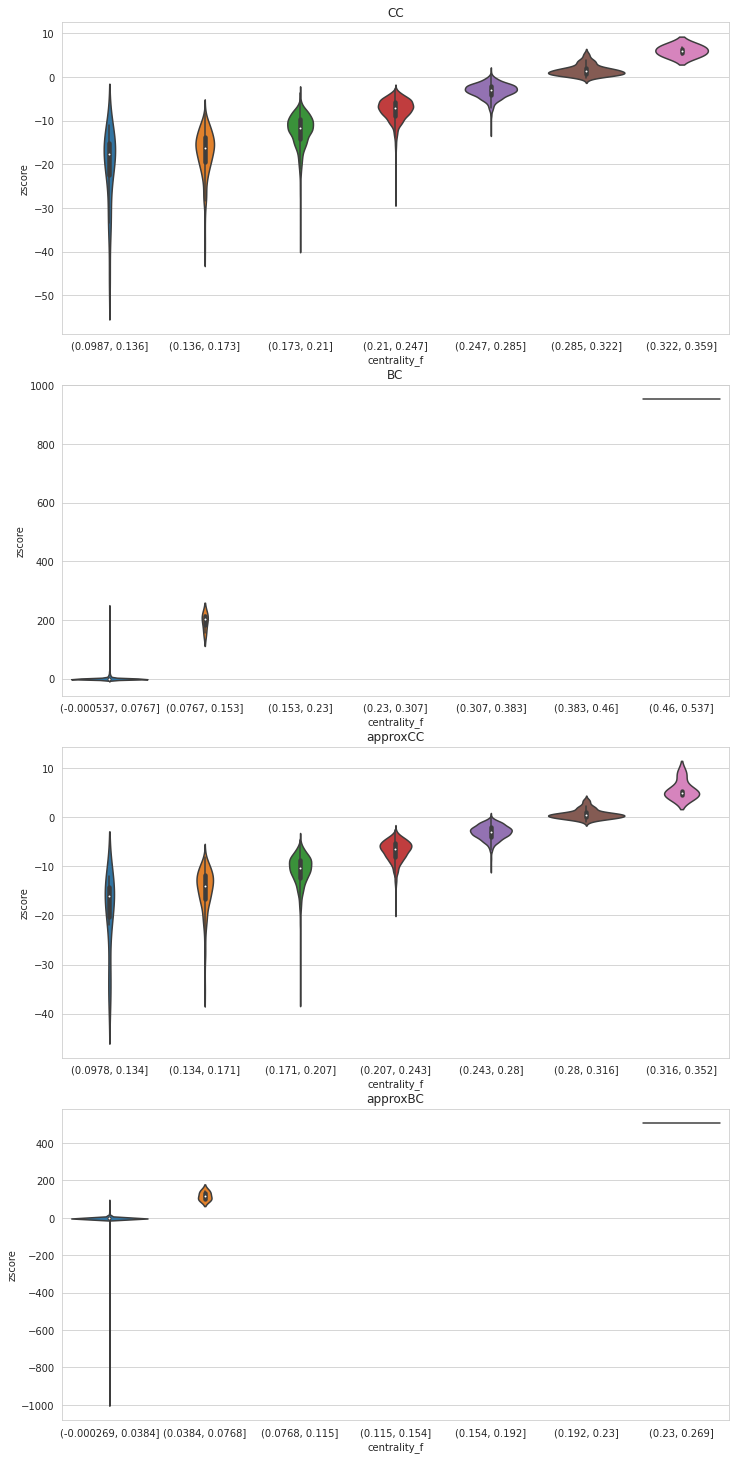

In [256]:
bins=7
fig, axes = plt.subplots(4,1,figsize=(10,20))
fig.tight_layout(h_pad=3)
sns.violinplot(x=pd.cut(df_test_CC['centrality_f'], bins), y='zscore', data=df_test_CC, ax=axes[0])
sns.violinplot(x=pd.cut(df_test_BC['centrality_f'], bins), y='zscore', data=df_test_BC, ax=axes[1])
sns.violinplot(x=pd.cut(df_test_approxCC['centrality_f'], bins), y='zscore', data=df_test_approxCC, ax=axes[2])
sns.violinplot(x=pd.cut(df_test_approxBC['centrality_f'], bins), y='zscore', data=df_test_approxBC, ax=axes[3])
axes[0].set_title("CC")
axes[1].set_title("BC")
axes[2].set_title("approxCC")
axes[3].set_title("approxBC")
plt.show()

In [279]:
df_test_LCC = generateDataFrame(nkG, "LCC", 10, "CL")

10it [00:00, 169.65it/s]


In [280]:
# no relation between centrality and clustering coefficient
df_test_LCC.loc[keys10bc][:5]

,zscore,clusteringCoeff_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,-0.539738,0.010471,0.015587,0.009479,0.7,0.3
177,2.898865,0.041825,0.023158,0.006439,0.0,1.0
157,5.723845,0.061489,0.022451,0.006820,0.0,1.0
810,-1.698537,0.010563,0.021752,0.006587,0.9,0.1
255,10.990020,0.139546,0.020365,0.010845,0.0,1.0


In [259]:
df_test_LCC.loc[keys10cc][:5]

,zscore,clusteringCoeff_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
703,-0.996891,0.010471,0.025035,0.014609,0.9,0.1
853,6.550922,0.123345,0.024097,0.015150,0.0,1.0
941,9.786155,0.177548,0.027090,0.015375,0.0,1.0
855,11.351688,0.155249,0.030545,0.010986,0.0,1.0
228,6.072688,0.071461,0.021611,0.008209,0.0,1.0


In [260]:
r = df_test_LCC.index[np.isinf(df_test_LCC).any(1)]
#there are cases where the z-score is inf because of 0 std.
df_test_LCC.loc[r]

,zscore,clusteringCoeff_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
2508,inf,0.105376,0.0,0.0,0.0,1.0
2527,inf,0.063241,0.0,0.0,0.0,1.0
2709,inf,0.570076,0.0,0.0,0.0,1.0
2772,inf,0.200000,0.0,0.0,0.0,1.0
2938,inf,0.466667,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
5862,inf,1.000000,0.0,0.0,0.0,1.0
5874,inf,0.333333,0.0,0.0,0.0,1.0
5875,inf,1.000000,0.0,0.0,0.0,1.0


In [261]:
# or when f and std and mean are zero
s = df_test_LCC.index[np.isnan(df_test_LCC).any(1)]
df_test_LCC.loc[s]

,zscore,clusteringCoeff_f,mean_rand,std_rand,pvalue-ge,pvalue-le
key,,,,,,
2988,NaN,0.0,0.0,0.0,1.0,1.0
3206,NaN,0.0,0.0,0.0,1.0,1.0
3404,NaN,0.0,0.0,0.0,1.0,1.0
3433,NaN,0.0,0.0,0.0,1.0,1.0
3668,NaN,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...
5901,NaN,0.0,0.0,0.0,1.0,1.0
5902,NaN,0.0,0.0,0.0,1.0,1.0
5903,NaN,0.0,0.0,0.0,1.0,1.0


In [262]:
np.ceil(np.max(df_test_LCC[np.isfinite(df_test_LCC)])['zscore'])

362.0

In [263]:
df_test_LCC = df_test_LCC.clip(-100,np.ceil(np.max(df_test_LCC[np.isfinite(df_test_LCC)])['zscore']))

/home/cristianoc/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cristianoc/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'LCC')

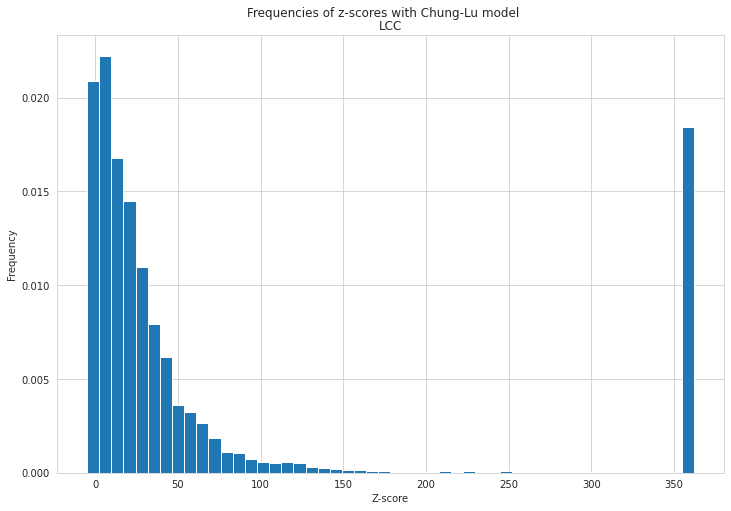

In [264]:
figure, axis = plt.subplots(1, 1, figsize=(10,7))
figure.suptitle("Frequencies of z-scores with Chung-Lu model")
figure.tight_layout(h_pad=3, w_pad=2)
axis.hist(df_test_LCC['zscore'], density=True, bins=50)
axis.set_ylabel('Frequency')
axis.set_xlabel('Z-score')
axis.set_title('LCC')

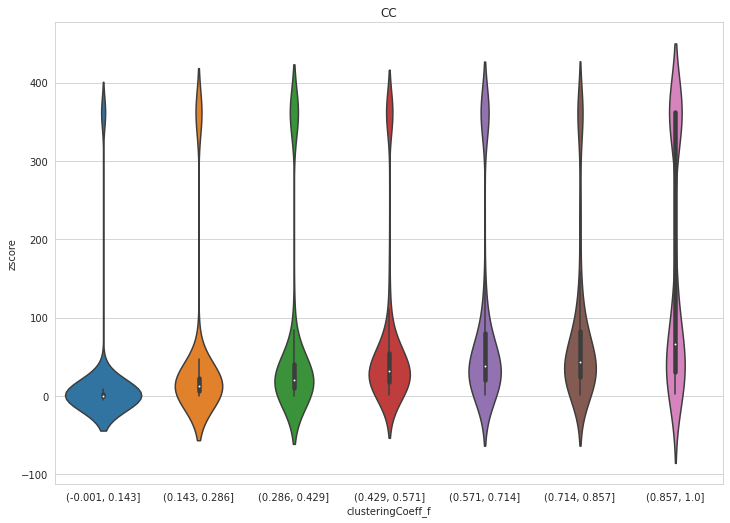

In [265]:
bins=7
fig, axes = plt.subplots(1,1,figsize=(10,7))
fig.tight_layout(h_pad=3)
sns.violinplot(x=pd.cut(df_test_LCC['clusteringCoeff_f'], bins), y='zscore', data=df_test_LCC, ax=axes)
axes.set_title("CC")
plt.show()

In [266]:
RndGraphs = generateRandGraphs("ER", 10, [nkG.numberOfNodes(), 0.0025])
globalClusteringCoeffRand = list(map(nk.globals.ClusteringCoefficient.exactGlobal,RndGraphs))
globalClusteringCoeff = nk.globals.ClusteringCoefficient.exactGlobal(nkG)
zscore_globalClusteringCoeff = zscore(globalClusteringCoeff, np.mean(globalClusteringCoeffRand), np.std(globalClusteringCoeffRand))

In [267]:
print("With Erdos Renyi model")
print("Global clustering coefficient: \n{}".format(globalClusteringCoeffRand))
print("z-score global clustering coefficient: {}".format(zscore_globalClusteringCoeff))

With Erdos Renyi model
Global clustering coefficient: 
[0.002438870421151658, 0.002426627315953435, 0.00236534602824881, 0.002600766167478215, 0.002492986522877369, 0.0024568731296724326, 0.0024933155397671956, 0.002393454442859606, 0.0024944258639910816, 0.0026780154594528796]
z-score global clustering coefficient: 3340.7053361170456


In [268]:
plarger_, psmaller_ = pvalues(globalClusteringCoeffRand, globalClusteringCoeff)
plarger_, psmaller_

(0.0, 1.0)

In [269]:
degreeSequence = [nkG.degree(v) for v in nkG.iterNodes()]
RndGraphs = generateRandGraphs("CL", 10, degreeSequence)
globalClusteringCoeffRand = list(map(nk.globals.ClusteringCoefficient.exactGlobal,RndGraphs))
globalClusteringCoeff = nk.globals.ClusteringCoefficient.exactGlobal(nkG)
zscore_globalClusteringCoeff = zscore(globalClusteringCoeff, np.mean(globalClusteringCoeffRand), np.std(globalClusteringCoeffRand))

In [270]:
print("With Chung-Lu model")
print("Global clustering coefficient: \n{}".format(globalClusteringCoeffRand))
print("z-score global clustering coefficient: {}".format(zscore_globalClusteringCoeff))

With Chung-Lu model
Global clustering coefficient: 
[0.020843222495039768, 0.021657711761744216, 0.022317099916072156, 0.021489518772521875, 0.020886542450161985, 0.02128215119927683, 0.021046769671133784, 0.022208714448897077, 0.02243728562112002, 0.021362043337742564]
z-score global clustering coefficient: 500.06212181319563


In [271]:
plarger_, psmaller_ = pvalues(globalClusteringCoeffRand, globalClusteringCoeff)
plarger_, psmaller_

(0.0, 1.0)